# Feature Extraction with PCA & SVD

**Table of Contents**
<div id="toc"></div>

## Preparation

In [1]:
import ConfigParser
config = ConfigParser.ConfigParser()
config.read('config.ini')

import pandas as pd
import numpy as np
import time
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

if config.getboolean('Booleans', 'UseLessFeatures') == True:
    n_features = 5
else:
    n_features = 11
    
gtd = pd.read_csv('gtd_processed_%dfeatures.csv' % n_features, encoding='latin1', low_memory=False)

In [2]:
gtd.tail(5)

,gname,iyear,country,attacktype1,weaptype1,targtype1
88652,Taliban,2016,4,9,13,4
88653,Taliban,2016,4,3,6,17
88654,Boko Haram,2016,146,9,13,4
88655,Lord's Resistance Army (LRA),2016,229,6,13,14
88656,Sudan Liberation Movement,2016,195,2,5,14


In [3]:
if config.getboolean('Booleans', 'UseLessFeatures') == True:
    features = gtd[['iyear', 'country', 'attacktype1', 'weaptype1', 'targtype1']]    
else:
    features = gtd[['iyear', 'country', 'crit1', 'crit2', 'crit3', 'attacktype1', 'targtype1', 
                'targsubtype1', 'weaptype1', 'weapsubtype1', 'ransom']]

In [4]:
df = (pd.DataFrame(features)).to_dict(orient='records')
dv = DictVectorizer(sparse=False) 
features = dv.fit_transform(features.to_dict(orient='records'))

In [5]:
array = gtd.values
X = array[:,1:]
target = array[:,0]

## PCA

In [6]:
pca = PCA(n_components=n_features)
reducedPCAFeatures = pca.fit_transform(features)

### Variance

In [7]:
print pca.explained_variance_

[  1.61460907e+04   1.81297756e+02   4.30494298e+01   8.44158572e+00
   1.50322621e+00]


### Variance Ratio

In [8]:
print pca.explained_variance_ratio_

[  9.85696793e-01   1.10679805e-02   2.62810891e-03   5.15347283e-04
   9.17699081e-05]


### Variance Ratio Cumulative Sum

In [9]:
print pca.explained_variance_ratio_.cumsum()

[ 0.98569679  0.99676477  0.99939288  0.99990823  1.        ]


So we would also retain 99.6% of the variance with 3 components for n_features = 11, 99.6% of the variance with 2 components for n_features=5

### Refit

In [10]:
pca = PCA(n_components=3)
reducedPCAFeatures = pca.fit_transform(features)

Split for PCA:

In [11]:
X_train_PCA, X_test_PCA, Y_train_PCA, Y_test_PCA = train_test_split(reducedPCAFeatures, target, test_size=0.30)

## SVD:

In [12]:
svd = TruncatedSVD(n_components=n_features-1)
reducedSVDFeatures = svd.fit_transform(features)

### Variance

In [13]:
print svd.explained_variance_

[  2.17891529e+02   1.61092861e+04   4.31840913e+01   8.50124144e+00]


### Variance Ratio

In [14]:
print svd.explained_variance_ratio_

[  1.33019804e-02   9.83449924e-01   2.63632982e-03   5.18989183e-04]


### Variance Ratio Cumulative Sum

In [15]:
print svd.explained_variance_ratio_.cumsum()

[ 0.01330198  0.9967519   0.99938823  0.99990722]


So we would also retain 99.6% of the variance with 3 components for n_features = 11, 99.6% of the variance with 2 components for n_features=5

### Refit

In [16]:
svd = TruncatedSVD(n_components=3)
reducedSVDFeatures = svd.fit_transform(features)

Split for SVD:

In [17]:
X_train_SVD, X_test_SVD, Y_train_SVD, Y_test_SVD = train_test_split(reducedSVDFeatures, target, test_size=0.30)

## Classifying

In [18]:
models = []
models.append(('KNC', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier()))

if config.getboolean('Booleans', 'RunPoorPerformingClassifiers') == True:
    models.append(('GNB', GaussianNB())) # GNB: 0.353792% (0.002758) - 9.339 seconds
    models.append(('LDA', LinearDiscriminantAnalysis())) #LDA: 0.285051% (0.004282) - 5.299 seconds

if config.getboolean('Booleans', 'RunRandomForest') == True:
    models.append(('RF', RandomForestClassifier()))

if config.getboolean('Booleans', 'RunSVM') == True:
    models.append(('SVM', SVC())) #Too slow for this many samples - O(N^3)

results = []
names = []
scoring = 'accuracy'
seed = 188

### PCA

In [19]:
for name, model in models:
    start_time = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed) #ensure same seed so models are directly comparable
    cv_results = model_selection.cross_val_score(model, X_train_PCA, Y_train_PCA, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append("%s_PCA" % name)
    msg = "%s: %f%% (%f) - %s seconds" % (name, cv_results.mean(), cv_results.std(), round((time.time() - start_time),3))
    print(msg)

KNC: 0.684075% (0.007088) - 6.543 seconds
DTC: 0.701623% (0.004731) - 25.529 seconds


#### Predicting on Validation set

In [20]:
array = gtd.values
seed = 188
X = array[:,1:]
Y = array[:,0]
validation_size = 0.10
X_train_PCA, X_validation, Y_train_PCA, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [21]:
cart = DecisionTreeClassifier()
cart.fit(X_train_PCA, Y_train_PCA)
predictions = cart.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.718362282878
[[1 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 2 0 0]
 [0 0 0 ..., 0 0 0]]
                                                                               precision    recall  f1-score   support

                                                                        1 May       1.00      1.00      1.00         1
                                                                   14 K Triad       1.00      1.00      1.00         1
                        16 January Organization for the Liberation of Tripoli       0.40      1.00      0.57         2
                                                                2 April Group       0.50      1.00      0.67         1
                                                  20 December Movement (M-20)       1.00      1.00      1.00         3
                                           23rd of September Communist League       0.50      0.50      0.50         4
                       

/Users/spe_eddy_gonzalez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/spe_eddy_gonzalez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### SVD

In [22]:
for name, model in models:
    start_time = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed) #ensure same seed so models are directly comparable
    cv_results = model_selection.cross_val_score(model, X_train_SVD, Y_train_SVD, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append("%s_SVD" % name)
    msg = "%s: %f%% (%f) - %s seconds" % (name, cv_results.mean(), cv_results.std(), round((time.time() - start_time),3))
    print(msg)

KNC: 0.684655% (0.004207) - 6.362 seconds
DTC: 0.703766% (0.006122) - 26.872 seconds


#### Result Plot:

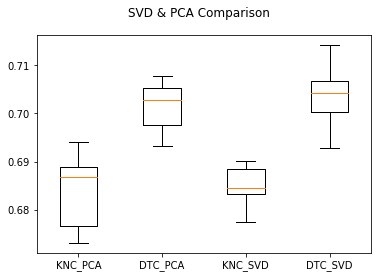

In [23]:
fig = plt.figure()
fig.suptitle('SVD & PCA Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Predicting on Validation set

In [24]:
array = gtd.values
seed = 188
X = array[:,1:]
Y = array[:,0]
validation_size = 0.10
X_train_SVD, X_validation, Y_train_SVD, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [25]:
cart = DecisionTreeClassifier()
cart.fit(X_train_SVD, Y_train_SVD)
predictions = cart.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.718475073314
[[1 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 2 0 0]
 [0 0 0 ..., 0 0 0]]
                                                                               precision    recall  f1-score   support

                                                                        1 May       1.00      1.00      1.00         1
                                                                   14 K Triad       1.00      1.00      1.00         1
                        16 January Organization for the Liberation of Tripoli       0.40      1.00      0.57         2
                                                                2 April Group       0.50      1.00      0.67         1
                                                  20 December Movement (M-20)       1.00      1.00      1.00         3
                                           23rd of September Communist League       0.50      0.50      0.50         4
                       